In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import random
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import datasets
import seaborn as sns
#from fancyimpute import KNN, SimpleFill

np.set_printoptions(precision=4)
np.set_printoptions(threshold=2000)

# TODO

- Update seeds so this runs consistently every time
- Predictions for various classifiers
- Draw decision boundaries

# Helper Functions

## Missing Data

In [2]:
#Creates a copy of a data frame. Each row of each predictor has a [probability] chance of being converted to NaN
def createNaNValues(df, probability = 0.2):
    df = df.copy()
    missingArray = np.random.binomial(size = df.shape[0], n = 1, p = probability)
    #Loop through columns (assumes these are all features)
    for i in range(df.shape[1]):
        df.iloc[np.array(missingArray, dtype=bool),i] = np.nan
    return df
    

## Class Imbalance

In [3]:
#Todo - would like to create class imbalance without changing the overall # of observations
def dropClassObservations(df,k=1,percentage=0):
    df = df.copy()
    obsToDrop = percentage * df[df["Y"]==1].shape[0]
    drop_indices = np.random.choice(df[df['Y']==1].index, int(obsToDrop), replace=False)
    return df.drop(drop_indices)

## Non-Normally Distributed Data

In [4]:

#Sample function to transform skewed data
def addOne(x):
    return np.add(x,np.ones(x.shape[0]))

#Replace a dataframe column with skewed data. Transforms class 1 observation values by some function
def replaceColumnWithSkewedData(df,column,transformFunc=addOne, degreesFree = 7, scaling = 20):
    df = df.copy()
    #Negative class
    df.loc[df["Y"]==0,column] = np.random.noncentral_chisquare(df=degreesFree, nonc=0, size = df[df["Y"] == 0].shape[0])/scaling
    #Positive class
    df.loc[df["Y"]==1,column] = transformFunc(np.random.noncentral_chisquare(df=degreesFree, nonc=0, size = df[df["Y"] ==1].shape[0])/scaling)
    return df

## Collinear Data

In [5]:
def replaceColumnWithCollinearColumn(df,sourceColumn, targetColumn, noiseStd, class1TransformFunc, class0TransformFunc):
    df = df.copy()
    class0Size = df.loc[df["Y"]==0,targetColumn].shape[0]
    class1Size = df.loc[df["Y"]==1,targetColumn].shape[0]
    df.loc[df["Y"]==0,targetColumn] = np.add(class0TransformFunc(df.loc[df["Y"]==0,sourceColumn]),np.random.normal(0,noiseStd,size=class0Size))
    df.loc[df["Y"]==1,targetColumn] = np.add(class1TransformFunc(df.loc[df["Y"]==1,sourceColumn]),np.random.normal(0,noiseStd,size=class1Size))
    return df

## Generating Data

In [6]:
#Create a single dataframe of length n
def generateDataFrame(n=1000,features=2,informative=2,classImbalance = 0,n_redundant=0,classSeparation=1):
                      
    if classImbalance > 0:
        #Generate more data so we end up with n observations after dropping class imbalance rows
        n = n + (classImbalance * .5 * n)
        
    X,Y = datasets.make_classification(n_samples = int(n),
                                       n_features=features,
                                       n_redundant=n_redundant ,
                                       n_informative=informative,
                                       n_clusters_per_class=1,
                                       class_sep=classSeparation,
                                       random_state=3)
    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    #Merge into 1 dataframe
    Y=Y.rename(index=str,columns={0:"Y"})
    Y.reset_index(drop=True, inplace=True)
    df = pd.concat([X,Y],axis=1)
    
    if classImbalance > 0:
        df = dropClassObservations(df=df,k=1,percentage=classImbalance)
    
    return df

# Generate Data

In [7]:
#Generate data with high/low/zero degrees of issues discussed

#Correlated data
#Missing data
#Class imbalance
#Non-normal data
#p>>n

## Zero Issues

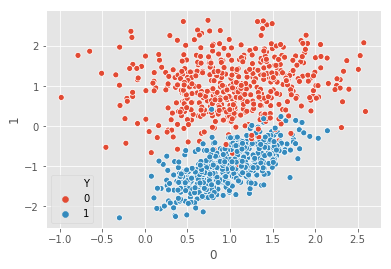

In [8]:
#Create pd dataframe
classImbalance = 0
classSeparation = 1
df = generateDataFrame(n=1000,features=2,informative=2,classImbalance = classImbalance, n_redundant =0, classSeparation = classSeparation)

#Train/test split
X = df.iloc[:,0:len(df.columns)-1] #grab only the features, assumes label is the last column
Y = df["Y"]
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25) #add random_state=1 later

sns.scatterplot(x=0,y=1,hue="Y",data=df)
plt.show()


## Medium Degree of Issues

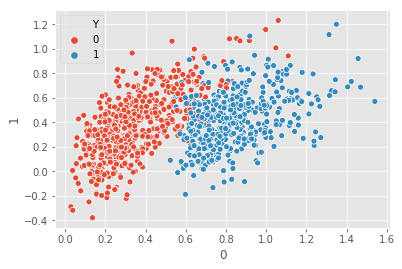

In [9]:
classImbalance = .25
nanPercentage = .25
classSeparation = .5
n=1000
df = generateDataFrame(n=n,features=2,informative=2,classImbalance = classImbalance, classSeparation = classSeparation )

#Function to transform the 'skewed' class 1 observations 
def addClassSeparation(x):
    return x+classSeparation
#Replace column 0 with skewed data (chi square distribution)
#Degrees free around 7 looks a little normal, but a little skewed. Dividing by 20 keeps it within 0-3
df = replaceColumnWithSkewedData(df,0,transformFunc=addClassSeparation, degreesFree = 7, scaling = 20)

#Collinear data
def class1TransformFunc(source):
    return source*.5
def class0TransformFunc(source):
    return source
df = replaceColumnWithCollinearColumn(df,sourceColumn=0, targetColumn=1, noiseStd=.2, class1TransformFunc=class1TransformFunc\
                                      , class0TransformFunc=class0TransformFunc)

#Train/test split
X = df.iloc[:,0:len(df.columns)-1] #grab only the features, assumes label is the last column
Y = df["Y"]

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25) #add random_state=1 later

#Generate missing values from data (have to run this after train/test split for some reason)
X = createNaNValues(X, probability = nanPercentage)
X_test = createNaNValues(X_test, probability = nanPercentage)

sns.scatterplot(x=0,y=1,hue="Y",data=df)
plt.show()


## High Degree of Issues

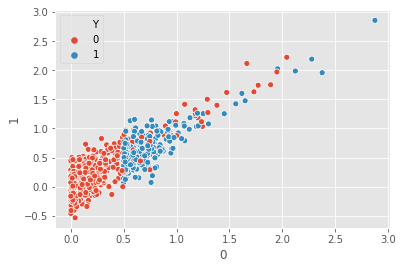

In [10]:
classImbalance = .5
nanPercentage = .5
classSeparation = .5
n=1000
df = generateDataFrame(n=n,features=2,informative=2,classImbalance = classImbalance, classSeparation = classSeparation )

#Function to transform the 'skewed' class 1 observations 
def addClassSeparation(x):
    return x+classSeparation
#Replace column 0 with skewed data (chi square distribution)
#Degrees free around 1 is highly skewed
df = replaceColumnWithSkewedData(df,0,transformFunc=addClassSeparation, degreesFree = 1, scaling = 5)

#Collinear data
def class1TransformFunc(source):
    return source*.9
def class0TransformFunc(source):
    return source
df = replaceColumnWithCollinearColumn(df,sourceColumn=0, targetColumn=1, noiseStd=.2, class1TransformFunc=class1TransformFunc\
                                      , class0TransformFunc=class0TransformFunc)

#Train/test split
X = df.iloc[:,0:len(df.columns)-1] #grab only the features, assumes label is the last column
Y = df["Y"]

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25) #add random_state=1 later

#Generate missing values from data (have to run this after train/test split for some reason)
X = createNaNValues(X, probability = nanPercentage)
X_test = createNaNValues(X_test, probability = nanPercentage)

sns.scatterplot(x=0,y=1,hue="Y",data=df)
plt.show()
